# Theory

at every gridpoint the following wavefield relationship is applied:


$q^+=p^++\delta s$ (total downgoing wavefield)

$q^-=p^-+\delta s$ (total upgoing wavefield)

$ \delta s \approx r^{\cup}p^++r^{\cap}p^-$ (scattering term; under acoustic approximation)

# Content

In this demo we will run demo of running 2D fwmod using one-way wave equation. Reflectivity operator is defined as independent values (that can be estimated from inversion)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import interactive
interactive(True)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [53]:
#define 1.5d fwmod function
def fwmod(wav,vel,r,dz,dx,nw,df,nx=1,norder=1,ixsrc=None):
    if ixsrc==None:
      ixsrc=nx//2
    nz=r.shape[-1]
    p=(1+0j)*np.zeros((nx,nw))
    pplus=(1+0j)*np.zeros((nx,nw,nz))
    pminus=(1+0j)*np.zeros((nx,nw,nz))
    w = (1 + 0j) * np.hstack((np.arange(0, nw))) * 2 * m.pi * df
    w = w.reshape((1,-1))
    kx = np.hstack((np.arange(0, (nx / 2)), np.arange(-(nx / 2), 0))) * 2 * m.pi / nx / dx
    kx = kx.reshape((-1,1))
    
    if nx==1:
        kx=0
    
    tap = np.ones((nx, 1))
    npad = 20
    tap[:npad,:] = np.squeeze(np.linspace(0, 1, npad)).reshape((-1,1))
    tap[-npad:,:] = tap[npad - 1::-1,:]
    tap = np.roll(tap, nx // 2, axis=-1)

    for order in range(norder):
        #down
        p=(1+0j)*np.zeros((nx,nw))
        p[ixsrc,:]=(1+0j)*wav 
        
        for iz in range(0,nz-1,1):
            k = w / vel[...,iz].reshape((-1,1))
            kz = np.conj(np.sqrt((1+0j)*k**2 - kx**2))
            woper = np.exp( -1j*kz * dz)
            vel_m=np.min(vel[...,iz].reshape((-1,1)))
            #print(1/vel[...,iz]-vel_m.shape)
            p=p*np.exp(-1j*w*(1/vel[...,iz].reshape((-1,1))-1/vel_m)*dz)
            p=p+r[...,iz].reshape((-1,1))*(p-pminus[...,iz])
            p=np.fft.ifft(woper*np.fft.fft(p,axis=0),axis=0)
           
            pplus[...,iz+1]=p
            if iz % 5 == 0:
                p *= tap
                
        #up
        p*=0
        for iz in range(nz-1,0,-1):
            k = w / vel[...,iz].reshape((-1,1))
            kz = np.conj(np.sqrt((1+0j)*k**2 - kx**2))
            woper = np.exp( -1j*kz * dz)
            vel_m=np.min(vel[...,iz])
            p=p*np.exp(-1j*w*(1/vel[...,iz].reshape((-1,1))-1/vel_m)*dz)
            p=p+r[...,iz].reshape((-1,1))*(pplus[...,iz]-p)
            p=np.fft.ifft(woper*np.fft.fft(p,axis=0),axis=0)
           
            pminus[...,iz-1]=p
            if iz % 5 == 0:
                p *= tap
         
    return p,pplus,pminus

(51,)


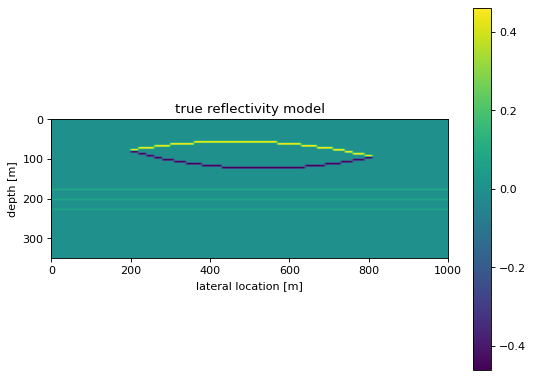

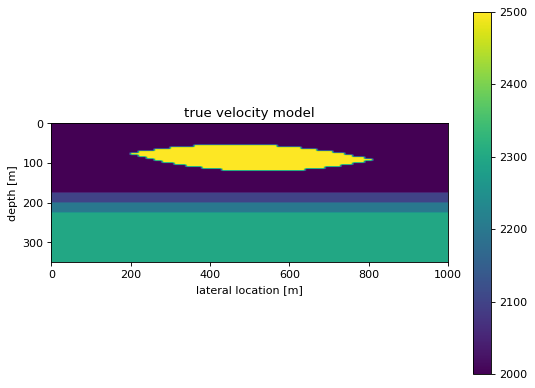

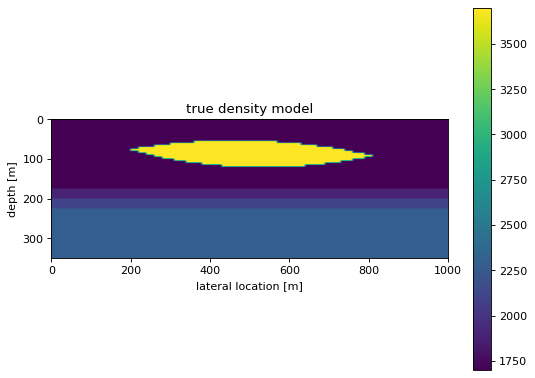

In [95]:
#define model
nx=300
nz=70


case=2

if case==1:
  c=1500*np.ones((nx,nz))
  vs=1000*np.ones((nx,nz))
  rho=1000*np.ones((nx,nz))
  r=np.zeros((nx,nz))
  z1=20
  z2=40
  r[:,z1]=0.5
  r[:,z2]=-0.5
  c[:,z1:z2]=2500

  dx=5
  dz=5

if case==2:
  nx=100
  nz=70
  c=1500*np.ones((nx,nz))
  vs=1000*np.ones((nx,nz))
  rho=1000*np.ones((nx,nz))
  r=np.zeros((nx,nz))

  # define the background velocities, densities and depth levels
  v=np.array([2000, 2000, 2000, 2100, 2200, 2300])
  d=np.array([1700, 1700, 1700, 1900, 2100, 2300])
  z=np.array([0, 5, 10, 35, 40, 45, nz])

  # define lens perturbation
  pertvel=500
  pertden=2000
  xtop=np.array([20, 60, 81])
  xbot = np.array([xtop[0], 40,xtop[-1]])

  vel = np.zeros((nz, nx))
  den = np.zeros((nz, nx))
  r = np.zeros((nx, nz))


  # fill background velocities
  for iz in range(z.size-1):
      c[:,z[iz]:z[iz+1]] = v[iz]
      rho[:,z[iz]:z[iz+1]] = d[iz]

  # polynomial interpolation for the lens
  pol_top = np.array([0.0063, -0.3259, 16])
  pol_bot = np.array([-0.0075, 0.5, 16])

  ztop_full = np.round(np.polyval(pol_top, np.arange(0, xtop[-1] - xtop[0] + 1)))
  zbot_full = np.round(np.polyval(pol_bot, np.arange(0, xbot[-1] - xbot[0] + 1)))

  ztop_full = ztop_full.astype(int)
  zbot_full = zbot_full.astype(int)


  # fill the perturbation
  vpert = np.zeros((nz, nx))
  dpert = np.zeros((nz, nx))
  for ix in range(xtop[0],xtop[-1]+1):
      vpert[(ztop_full[ix-xtop[0]] -1) : zbot_full[ix-xtop[0]], ix] = pertvel
      dpert[(ztop_full[ix-xtop[0]] -1) : zbot_full[ix-xtop[0]], ix] = pertden

  c+=vpert.T
  rho+=dpert.T
    
  r_factor=1
  for iz in range(1,nz-1):
    imp1=c[:,iz-1]*rho[:,iz-1]
    imp2=c[:,iz]*rho[:,iz]
    r[:,iz] =  r_factor* (imp2 - imp1) / (imp2 + imp1) 
  #r[nx//2-20:nx//2+20,20]=0.5
  #r[nx//2-20:nx//2+20,30]=-0.5
  #c[nx//2-20:nx//2+20,20:30]=2500
  

  

  dx=10
  dz=5


dt=0.004
nt=256

fmax=50
df=1/nt/dt
nw=int(fmax/df)
wav=np.ones((nw,))

def ricker(f, length=0.128, dt=0.001,t0=0.1):
    t = np.arange(0-t0, (length-dt)-t0, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y
 
f = 0.75*fmax//2
_, y = ricker(f,nt*dt,dt)
#plt.plot(y)
#plt.show()
wav=np.fft.fft(y,n=nt)[:nw]
#plt.plot(np.abs(wav))
#plt.show()
print(wav.shape)
if nx==1:
    plt.plot(r.T)
else:
    extent=[0,nx*dx,nz*dz,0]
    figure(figsize=(8, 6), dpi=80)
    plt.imshow(r.T,extent=extent)
    plt.title('true reflectivity model')
    plt.xlabel('lateral location [m]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    plt.show()
    figure(figsize=(8, 6), dpi=80)
    plt.imshow(c.T,extent=extent)
    plt.title('true velocity model')
    plt.xlabel('lateral location [m]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    plt.show()
    figure(figsize=(8, 6), dpi=80)
    plt.imshow(rho.T,extent=extent)
    plt.title('true density model')
    plt.xlabel('lateral location [m]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    plt.show()
plt.show()
#########
orders=3
#########
p,pplus,pminus=fwmod(wav,c,r,dz,dx,nw,df,nx,norder=orders)

Pseudo-VSP viewer:

In [96]:
@interact(ix=widgets.IntSlider(min=0, max=nx-1, step=1, value=nx//2))
def vsp(ix):
  vsp_extent=[0,nt*dt-dt,nz*dz/1000,0]
  fig, axs = plt.subplots(3)
  fig.set_figheight(8)
  fig.set_figwidth(8)
  clip=0.3*np.max(np.real(np.fft.ifft(pplus,axis=1,n=nt)))
  print(clip)
  axs[0].clear() # <-- clear axes
  axs[0].imshow((np.real(np.fft.ifft(pplus+pminus,axis=1,n=nt)))[ix,...].T,cmap='gray',extent=vsp_extent,vmin=-clip,vmax=clip)
  axs[0].title.set_text('Total wavefield')
  #plt.title('Modeled VSP wavefield')
  #plt.show()
  axs[1].clear() # <-- clear axes
  axs[1].imshow((np.real(np.fft.ifft(pplus,axis=1,n=nt)))[ix,...].T,cmap='gray',extent=vsp_extent,vmin=-clip,vmax=clip)
  axs[1].title.set_text('Downgoing wavefield')
  #plt.title('... downgoing component')
  #plt.show()
  axs[2].clear() # <-- clear axes
  axs[2].imshow((np.real(np.fft.ifft(pminus,axis=1,n=nt)))[ix,...].T,cmap='gray',extent=vsp_extent,vmin=-clip,vmax=clip)
  axs[2].title.set_text('Upgoing wavefield')
  #plt.title('... upgoing component')
  fig.text(0.5, 0.04, 'Time [s]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Depth [km]', ha='center', va='center', rotation='vertical')


  plt.show()
  #plt.imshow(np.real(np.fft.ifft(p,n=nt)).T)
  #plt.title('upgoing wavefield at the surface')
  #plt.show()

interactive(children=(IntSlider(value=50, description='ix', max=99), Output()), _dom_classes=('widget-interact…

Depth viewer:

In [100]:
@interact(iz=widgets.IntSlider(min=0, max=nz-1, step=1, value=1))
def depth(iz):
  fig, axs = plt.subplots(1,2)
  fig.set_figheight(8)
  fig.set_figwidth(8)
  extent = [0, nz*dz/1000, 0 + nt*dt, 0]
  clip=0.1*np.max(np.real(np.fft.ifft(pplus,axis=1,n=nt)))
  axs[0].clear() # <-- clear axes
  axs[0].imshow((np.real(np.fft.ifft(pplus,axis=1,n=nt)))[...,iz].T,cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[0].title.set_text('downgoing wavefield')
  #plt.title('... downgoing component')
  #plt.show()
  axs[1].clear() # <-- clear axes
  axs[1].imshow((np.real(np.fft.ifft(pminus,axis=1,n=nt)))[...,iz].T,cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[1].title.set_text('upgoing wavefield')
  fig.text(0.5, 0.04, 'Lateral location [m]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Time [s]', ha='center', va='center', rotation='vertical')
  #plt.title('... upgoing component')
  plt.show()
  #plt.imshow(np.real(np.fft.ifft(p,n=nt)).T)
  #plt.title('upgoing wavefield at the surface')
  #plt.show()

interactive(children=(IntSlider(value=1, description='iz', max=69), Output()), _dom_classes=('widget-interact'…

Snapshot wavefield viewer:

In [101]:
@interact(it=widgets.IntSlider(min=0, max=nt-1, step=1, value=61))
def snap(it):
  extent=[0,nx*dx,nz*dz,0]
  fig, axs = plt.subplots(3,1)
  fig.set_figheight(14)
  fig.set_figwidth(14)
  clip=0.1*np.max(np.real(np.fft.ifft(pplus,axis=1,n=nt)))
  axs[0].clear() # <-- clear axes
  im=axs[0].imshow((np.real(np.fft.ifft(pplus+pminus,axis=1,n=nt)))[:,it,:].T,cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[0].title.set_text('total wavefield')
  #fig.colorbar(im, cax=axs[0])
  #axs[0].colorbar()

  axs[1].clear() # <-- clear axes
  axs[1].imshow((np.real(np.fft.ifft(pplus,axis=1,n=nt)))[:,it,:].T,cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[1].title.set_text('downgoing wavefield')
  #fig.colorbar(im, cax=axs[1])
  #plt.show()
  axs[2].clear() # <-- clear axes
  axs[2].imshow((np.real(np.fft.ifft(pminus,axis=1,n=nt)))[:,it,:].T,cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[2].title.set_text('upgoing wavefield')
  #fig.colorbar(im, cax=axs[2])
  #plt.title('... upgoing component')
  #plt.colorbar()
  fig.text(0.5, 0.04, 'Lateral location [m]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical')
  plt.show()
  #plt.imshow(np.real(np.fft.ifft(p,n=nt)).T)
  #plt.title('upgoing wavefield at the surface')
  #plt.show()


interactive(children=(IntSlider(value=61, description='it', max=255), Output()), _dom_classes=('widget-interac…

Simple inversion example, multiple shots are used

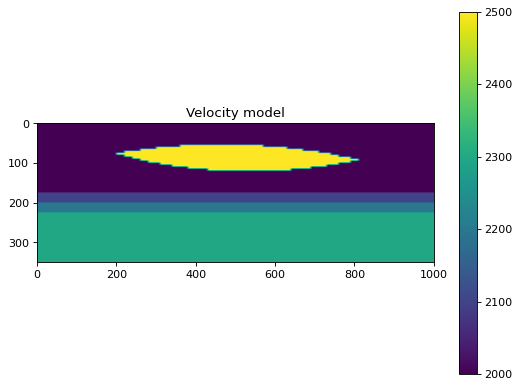

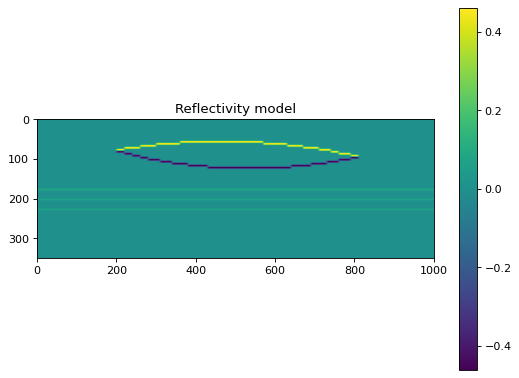

iteration 0 obj 1.0


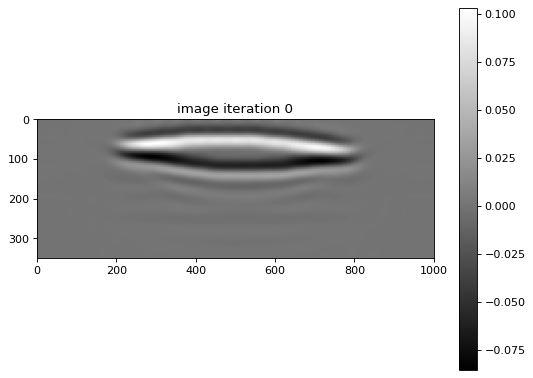

iteration 1 obj 0.34484425981367534
iteration 2 obj 0.16909687510159258
iteration 3 obj 0.10064634311773787
iteration 4 obj 0.06665925796117032
iteration 5 obj 0.049226648067180474
iteration 6 obj 0.03825093479493485
iteration 7 obj 0.03358308866319752
iteration 8 obj 0.02876003021426683
iteration 9 obj 0.025407313011630447


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

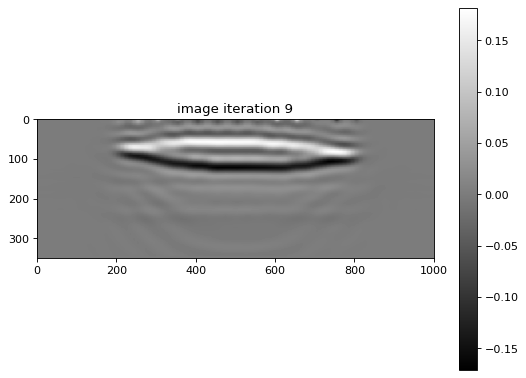

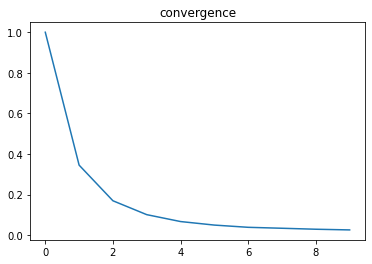

In [103]:
######
fwm=1 # 1: full-wavefield imaging, 2: primaries-only imaging


rest=0*np.copy(r)
iters=10
conv=[]
orders=3
if fwm==0:
  orders=1
nsrc=20
extent=[0,nx*dx,nz*dz,0]
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.imshow(c.T,extent=extent)
plt.title('Velocity model')
plt.colorbar()
plt.show()
figure(figsize=(8, 6), dpi=80)
plt.imshow(r.T,extent=extent)
plt.colorbar()
plt.title('Reflectivity model')
plt.show()
observed=[]
for ishot in range(nsrc):
  pobs,_,_=fwmod(wav,c,r,dz,dx,nw,df,nx,norder=3,ixsrc=nx//nsrc*ishot)

  observed.append(pobs)
 

for iter in range(iters):
  residuals=[]
  dr=0*np.copy(r)
  nz=r.shape[-1]
  fx=0
  for ishot in range(nsrc):
    pmod,pplus,pminus=fwmod(wav,c,rest,dz,dx,nw,df,nx,norder=orders,ixsrc=nx//nsrc*ishot)
    pres=observed[ishot]-pmod
    residuals.append(pres)
    fx+=(np.real(np.sum(pres*np.conj(pres))))
    #imaging/back-propagation
    p=(1+0j)*np.zeros((nx,nw))
    w = (1 + 0j) * np.hstack((np.arange(0, nw))) * 2 * m.pi * df
    w = w.reshape((1,-1))
    kx = np.hstack((np.arange(0, (nx / 2)), np.arange(-(nx / 2), 0))) * 2 * m.pi / nx / dx
    kx = kx.reshape((-1,1))
    if nx==1:
      kx=0
    tap = np.ones((nx, 1))
    npad = 20
    tap[:npad,:] = np.squeeze(np.linspace(0, 1, npad)).reshape((-1,1))
    tap[-npad:,:] = tap[npad - 1::-1,:]
    tap = np.roll(tap, nx // 2, axis=-1)
    #down
    p=residuals[ishot]
    vel=c       
    for iz in range(0,nz-1,1):
        k = w / vel[...,iz].reshape((-1,1))
        kz = np.conj(np.sqrt((1+0j)*k**2 - kx**2))
        woper = np.exp( -1j*kz * dz)
        vel_m=np.min(vel[...,iz].reshape((-1,1)))
        p=np.fft.ifft(np.conj(woper)*np.fft.fft(p,axis=0),axis=0)
        p=p*np.exp(1j*w*(1/vel[...,iz].reshape((-1,1))-1/vel_m)*dz)

        if iz % 10 == 0:
            p *= tap
  
        dr[...,iz]+=np.real(np.sum(p*np.conj(pplus[...,iz+1]),axis=1))
  #dr[:,:]=0
  #plt.imshow(dr.T,cmap='gray')
  #plt.show()
  aa=bb=0
  conv.append(fx)
  dr=dr/np.max(np.abs(dr))/100
  
  for ishot in range(nsrc):
    #linesearch
    dp,_,_=fwmod(wav,c,dr,dz,dx,nw,df,nx,norder=1,ixsrc=nx//nsrc*ishot)

    #plt.imshow(np.real(np.fft.ifft(dp,n=nt)).T)
    #plt.show()
    #plt.imshow(np.real(np.fft.ifft(residuals[ishot],n=nt)).T)
    #plt.show()

    aa+=np.real(np.sum(dp*np.conj(residuals[ishot])+np.conj(dp)*residuals[ishot]))
    bb+=np.real(np.sum(np.conj(dp)*dp))

  alpha=0.5*aa/bb
  print(f'iteration {iter} obj {fx/conv[0]}')

  rest+=alpha*dr
  figure(figsize=(8, 6), dpi=80)
  if iter==0 or iter==iters-1:
    plt.imshow(rest.T,cmap='gray',extent=extent)
    plt.colorbar()
    plt.title(f'image iteration {iter}')
    plt.show()

plt.plot(conv/conv[0])
plt.title('convergence')
plt.show()